# Final Project: Link Prediction with NASA GES-DISC Dataset Part1

# Sagar Sheth
G32921700

# Data Exploration & Basline Models

1. The NASA Goddard Earth Sciences Data and Information Services Center (GES DISC) has developed a knowledge graph to enhance dataset discovery and research reproducibility. 
2. This graph connects various entities such as datasets, publications, instruments, platforms, authors, and science keywords, facilitating improved navigation and understanding of the relationships between these components.
3. By integrating machine learning techniques like link prediction, we can identify missing associations between datasets and science keywords. This approach enhances metadata completeness, thereby improving dataset discoverability.
4. Additionally, by utilizing GNN’s with RAG one can augment and enrich recommendations with more relevant content.

In [1]:
#!pip install torch_geometric
#!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.4.0+cu121.html

In [2]:
import pandas as pd
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
import networkx as nx
import ast
import matplotlib.pyplot as plt

In [3]:
# Load node and edge data
nodes_df = pd.read_csv('./Data/nodes.csv')
edges_df = pd.read_csv('./Data/train_edges.csv')


In [4]:
nodes_df

,id,label,properties
0,0,['Dataset'],{'abstract': 'The Atmospheric Infrared Sounder...
1,1,['Dataset'],{'abstract': 'Version 07 is the current versio...
2,2,['Dataset'],{'abstract': 'The Solar Backscattered Ultravio...
3,3,['Dataset'],{'abstract': 'The data presented in this level...
4,4,['Dataset'],{'abstract': 'The TROPESS CrIS-SNPP L2 for Sao...
...,...,...,...
5758,25019,['ScienceKeyword'],"{'name': 'WATER ION CONCENTRATIONS', 'globalId..."
5759,25020,['ScienceKeyword'],"{'name': 'WATER TRACE ELEMENTS', 'globalId': '..."
5760,25021,['ScienceKeyword'],"{'name': 'pH', 'globalId': 'd2cbb2ca-aaa2-54f1..."
5761,25022,['ScienceKeyword'],"{'name': 'WATER QUALITY INDEXES', 'globalId': ..."


In [5]:
edges_df

,source,target,relationship_type
0,1152,1354,OF_PROJECT
1,1317,1164,HAS_DATASET
2,1317,768,HAS_DATASET
3,1271,23795,HAS_SCIENCEKEYWORD
4,820,23837,HAS_SCIENCEKEYWORD
...,...,...,...
13815,21903,495,USES_DATASET
13816,1274,23723,HAS_SCIENCEKEYWORD
13817,12187,1208,USES_DATASET
13818,302,1373,HAS_PLATFORM


In [6]:
# Convert node and edge data to NetworkX graph for compatibility
G = nx.Graph()

for _, row in nodes_df.iterrows():
    G.add_node(row['id'])

for _, row in edges_df.iterrows():
    G.add_edge(row['source'], row['target'])

# Part 1: Exploring the NASA GES-DISC Dataset

### Finding the different kind of lables in the data 

In [7]:
unique_values = nodes_df['label'].unique()
print(unique_values)


["['Dataset']" "['DataCenter']" "['Project']" "['Platform']"
 "['Instrument']" "['Publication']" "['ScienceKeyword']"]


In [8]:
frequency_summary = nodes_df.groupby('label').size().reset_index(name='Frequency')


In [9]:
frequency_summary

,label,Frequency
0,['DataCenter'],1
1,['Dataset'],1300
2,['Instrument'],83
3,['Platform'],142
4,['Project'],44
5,['Publication'],2584
6,['ScienceKeyword'],1609


### Exploring what kind of nodes are connected to each other

In [10]:
edge_with_labels = edges_df.merge(nodes_df, left_on='source', right_on='id', how='left')
edge_with_labels = edge_with_labels.rename(columns={'label': 'source_label'})

edge_with_labels = edge_with_labels.drop(columns=['id','properties'])

edge_with_labels = edge_with_labels.merge(nodes_df, left_on='target', right_on='id', how='left')
edge_with_labels = edge_with_labels.rename(columns={'label': 'target_label'})

edge_with_labels = edge_with_labels.drop(columns=['id','properties'])


In [11]:
edge_with_labels

,source,target,relationship_type,source_label,target_label
0,1152,1354,OF_PROJECT,['Dataset'],['Project']
1,1317,1164,HAS_DATASET,['DataCenter'],['Dataset']
2,1317,768,HAS_DATASET,['DataCenter'],['Dataset']
3,1271,23795,HAS_SCIENCEKEYWORD,['Dataset'],['ScienceKeyword']
4,820,23837,HAS_SCIENCEKEYWORD,['Dataset'],['ScienceKeyword']
...,...,...,...,...,...
13815,21903,495,USES_DATASET,['Publication'],['Dataset']
13816,1274,23723,HAS_SCIENCEKEYWORD,['Dataset'],['ScienceKeyword']
13817,12187,1208,USES_DATASET,['Publication'],['Dataset']
13818,302,1373,HAS_PLATFORM,['Dataset'],['Platform']


In [12]:
connection_summary = edge_with_labels.groupby(['source_label', 'relationship_type', 'target_label']).size().reset_index(name='Connection_Count')

In [13]:
connection_summary

,source_label,relationship_type,target_label,Connection_Count
0,['DataCenter'],HAS_DATASET,['Dataset'],1300
1,['Dataset'],HAS_PLATFORM,['Platform'],1519
2,['Dataset'],HAS_SCIENCEKEYWORD,['ScienceKeyword'],4015
3,['Dataset'],OF_PROJECT,['Project'],1325
4,['Platform'],HAS_INSTRUMENT,['Instrument'],215
5,['Publication'],USES_DATASET,['Dataset'],3623
6,['ScienceKeyword'],SUBCATEGORY_OF,['ScienceKeyword'],1823


### Visualizing the graph

In [14]:
color_map = {
    "['Dataset']" : 'red',
    "['DataCenter']" : 'blue',
    "['Project']" : 'green',
    "['Platform']" : 'pink',
    "['Instrument']" : 'yellow',
    "['Publication']" : 'orange',
    "['ScienceKeyword']" : 'black'
}

In [15]:
node_colors = [color_map[row['label']] for _, row in nodes_df.iterrows()]

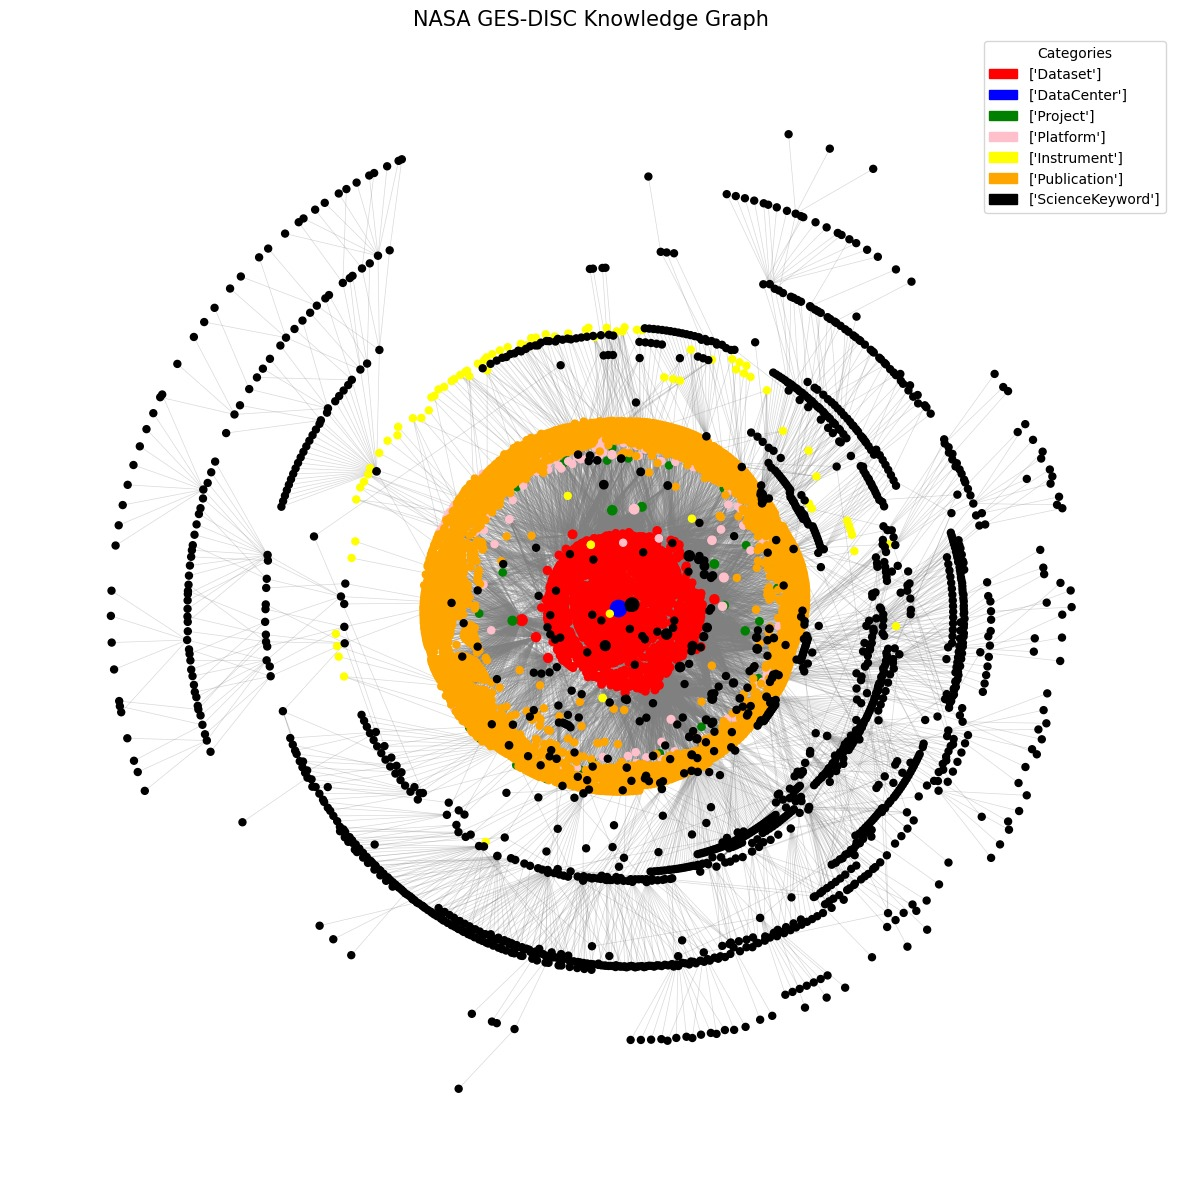

# Link Prediction

## Balseline Method 1 Jaccard Coefficient Approch to Predict Missing links

In [16]:
jaccard_predictions = list(nx.jaccard_coefficient(G))

In [17]:
import pandas as pd

# Load the test and validation edges
test_df = pd.read_csv('./Data/test_links.csv')
validation_df = pd.read_csv('./Data/val_links.csv')

### Test Dataset

In [18]:
test_edges = set(zip(test_df['source'], test_df['target']))

# Get Jaccard scores for test edges only
test_jaccard_scores = [(u, v, score) for u, v, score in jaccard_predictions if (u, v) in test_edges or (v, u) in test_edges]

In [19]:
# Defining a threshold to make a prediction
threshold = 0.001

predicted_edges = {(u, v) for u, v, score in test_jaccard_scores if score >= threshold}

true_positives = len(predicted_edges & test_edges)
false_positives = len(predicted_edges - test_edges)
false_negatives = len(test_edges - predicted_edges)

jd_test_precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
jd_test_recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
jd_test_f1_score = 2 * (jd_test_precision * jd_test_recall) / (jd_test_precision + jd_test_recall) if (jd_test_precision + jd_test_recall) > 0 else 0
jd_test_accuracy = true_positives / (true_positives + false_positives + false_negatives) if (true_positives + false_positives + false_negatives) > 0 else 0

#### Metrics

In [20]:
print(f"Accuracy: {jd_test_accuracy:.2f}")
print(f"Precision: {jd_test_precision:.2f}")
print(f"Recall: {jd_test_recall:.2f}")
print(f"F1-score: {jd_test_f1_score:.2f}")

Accuracy: 0.70
Precision: 1.00
Recall: 0.70
F1-score: 0.82


### Validation Dataset

In [21]:
val_edges = set(zip(validation_df['source'], validation_df['target']))

# Get Jaccard scores for test edges only
val_jaccard_scores = [(u, v, score) for u, v, score in jaccard_predictions if (u, v) in val_edges or (v, u) in val_edges]

In [22]:
# Defining a threshold to make a prediction
threshold = 0.001

predicted_edges = {(u, v) for u, v, score in val_jaccard_scores if score >= threshold}

true_positives = len(predicted_edges & val_edges)
false_positives = len(predicted_edges - val_edges)
false_negatives = len(val_edges - predicted_edges)

jd_val_precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
jd_val_recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
jd_val_f1_score = 2 * (jd_val_precision * jd_val_recall) / (jd_val_precision + jd_val_recall) if (jd_val_precision + jd_val_recall) > 0 else 0
jd_val_accuracy = true_positives / (true_positives + false_positives + false_negatives) if (true_positives + false_positives + false_negatives) > 0 else 0

#### Metrics

In [23]:
print(f"Accuracy: {jd_val_accuracy:.2f}")
print(f"Precision: {jd_val_precision:.2f}")
print(f"Recall: {jd_val_recall:.2f}")
print(f"F1-score: {jd_val_f1_score:.2f}")

Accuracy: 0.71
Precision: 1.00
Recall: 0.71
F1-score: 0.83


## Method 2 Embedding-Based Approach: Using Node2Vec to Create Vetor embeddings to prdict missing Links

In [24]:
#!pip install node2vec

In [25]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score
from node2vec import Node2Vec

In [26]:
# Initialize Node2Vec model with your graph
node2vec = Node2Vec(G, dimensions=64, walk_length=35, num_walks=150, workers=10)

# Fit model to learn embeddings
model = node2vec.fit(window=10, min_count=1, batch_words=4)

Computing transition probabilities:   0%|          | 0/5763 [00:00<?, ?it/s]

Generating walks (CPU: 9): 100%|██████████| 15/15 [00:26<00:00,  1.79s/it]


##### As during Random walks, some nodes may not be visited and therefore will not have embeddings, so avg of all node embeddings is taken as placeholder value

### 2.1 Edge Embedding using Hadamard product

In [27]:
avg_embedding = np.mean([model.wv[node] for node in model.wv.index_to_key], axis=0)

def get_edge_features(u, v, model):
    emb_u = model.wv[u] if u in model.wv else avg_embedding
    emb_v = model.wv[v] if v in model.wv else avg_embedding
    return emb_u * emb_v  # Hadamard product


In [28]:
positive_edges = list(G.edges())

non_edges = list(nx.non_edges(G))

import random
random.seed(100)

non_edges = list(nx.non_edges(G))
negative_edges = random.sample(non_edges, len(positive_edges))

positive_edges = [(u, v) for u, v in positive_edges if u in model.wv and v in model.wv]
negative_edges = [(u, v) for u, v in negative_edges if u in model.wv and v in model.wv]

##### Converting data into Target and Features to be inputted into a logistic regression model

In [29]:
X = [get_edge_features(u, v, model) for u, v in positive_edges] + [get_edge_features(u, v, model) for u, v in negative_edges]
y = [1] * len(positive_edges) + [0] * len(negative_edges)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### Only nodes which were visited are taken into consideration when building the model

#### 2.1.1 Logistic Regression

In [31]:
# Initialize and train logistic regression model
clf = LogisticRegression(random_state=0, max_iter=5000)
clf.fit(X_train, y_train)


LogisticRegression(max_iter=5000, random_state=0)

In [32]:
# Make predictions
y_pred = clf.predict(X_test)

# Calculate evaluation metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Precision: 0.79
Recall: 0.95
F1 Score: 0.86


##### Test Data Set

In [33]:
test_features = [get_edge_features(u, v, model) for u, v in test_edges]
test_predictions = clf.predict(test_features)

In [34]:
test_df['label']=1

In [35]:
# Assuming validation_df['label'] contains the ground truth labels for each edge in the validation set
test_labels = test_df['label'].values  # Actual labels for validation edges

# Calculate accuracy, precision, recall, and F1-score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

n2v_test_accuracy = accuracy_score(test_labels, test_predictions)
n2v_test_precision = precision_score(test_labels, test_predictions)
n2v_test_recall = recall_score(test_labels, test_predictions)
n2v_test_f1 = f1_score(test_labels, test_predictions)

###### Metrics

In [36]:
print(f"Accuracy: {n2v_test_accuracy:.2f}")
print(f"Precision: {n2v_test_precision:.2f}")
print(f"Recall: {n2v_test_recall:.2f}")
print(f"F1 Score: {n2v_test_f1:.2f}")

Accuracy: 0.87
Precision: 1.00
Recall: 0.87
F1 Score: 0.93


##### Validation Dataset

In [37]:
val_features = [get_edge_features(u, v, model) for u, v in val_edges]
val_predictions = clf.predict(val_features)

In [38]:
validation_df['label']=1

In [39]:
val_labels = validation_df['label'].values

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

n2v_val_accuracy = accuracy_score(val_labels, val_predictions)
n2v_val_precision = precision_score(val_labels, val_predictions)
n2v_val_recall = recall_score(val_labels, val_predictions)
n2v_val_f1 = f1_score(val_labels, val_predictions)

###### Metrics

In [40]:
print(f"Accuracy: {n2v_val_accuracy:.2f}")
print(f"Precision: {n2v_val_precision:.2f}")
print(f"Recall: {n2v_val_recall:.2f}")
print(f"F1 Score: {n2v_val_f1:.2f}")

Accuracy: 0.88
Precision: 1.00
Recall: 0.88
F1 Score: 0.94


#### 2.1.2 Neural Nets

In [41]:
X = [get_edge_features(u, v, model) for u, v in positive_edges] + [get_edge_features(u, v, model) for u, v in negative_edges]
y = [1] * len(positive_edges) + [0] * len(negative_edges)


In [42]:
X = np.array(X)
y = np.array(y)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the neural network model
model_nn = models.Sequential([
    layers.Dense(16, activation='relu', input_shape=(X.shape[1],)),
    layers.Dense(1, activation='sigmoid')
])
model_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

2024-12-15 22:58:05.696237: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-15 22:58:05.907666: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-15 22:58:05.980541: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-15 22:58:06.000549: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-15 22:58:06.134430: I tensorflow/core/platform/cpu_feature_guar

In [45]:
# Train the model
history = model_nn.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2)

Epoch 1/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7499 - loss: 0.6466 - val_accuracy: 0.7353 - val_loss: 0.5694
Epoch 2/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step - accuracy: 0.7454 - loss: 0.5568 - val_accuracy: 0.7381 - val_loss: 0.5397
Epoch 3/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step - accuracy: 0.7540 - loss: 0.5237 - val_accuracy: 0.7465 - val_loss: 0.5267
Epoch 4/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step - accuracy: 0.7441 - loss: 0.5238 - val_accuracy: 0.7493 - val_loss: 0.5210
Epoch 5/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step - accuracy: 0.7704 - loss: 0.4918 - val_accuracy: 0.7502 - val_loss: 0.5163
Epoch 6/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step - accuracy: 0.7729 - loss: 0.4937 - val_accuracy: 0.7502 - val_loss: 0.5141
Epoch 7/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - accuracy: 0.7689 - loss: 0.4830 - val_accuracy: 0.7446 - val_loss: 0.5120
Epoch 8/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - accuracy: 0.7924 - loss: 0.4619 - va

In [46]:
test_predictions = model_nn.predict(X_test)
test_predictions = (test_predictions > 0.5).astype(int)

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step


In [47]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate metrics
test_precision = precision_score(y_test, test_predictions)
test_recall = recall_score(y_test, test_predictions)
test_f1 = f1_score(y_test, test_predictions)

# Print results
test_loss, test_accuracy = model_nn.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Precision: {test_precision:.2f}")
print(f"Test Recall: {test_recall:.2f}")
print(f"Test F1 Score: {test_f1:.2f}")

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - accuracy: 0.7727 - loss: 0.4834
Test Accuracy: 0.78
Test Precision: 0.81
Test Recall: 0.92
Test F1 Score: 0.86


##### Test Data

In [48]:
test_features = [get_edge_features(u, v, model) for u, v in test_edges]
test_predictions = model_nn.predict(np.array(test_features))
test_predictions = (test_predictions > 0.5).astype(int)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step


In [49]:
nn_test_accuracy = accuracy_score(test_labels, test_predictions)
nn_test_precision = precision_score(test_labels, test_predictions)
nn_test_recall = recall_score(test_labels, test_predictions)
nn_test_f1 = f1_score(test_labels, test_predictions)

print(f"Accuracy: {nn_test_accuracy:.2f}")
print(f"Precision: {nn_test_precision:.2f}")
print(f"Recall: {nn_test_recall:.2f}")
print(f"F1 Score: {nn_test_f1:.2f}")

Accuracy: 0.71
Precision: 1.00
Recall: 0.71
F1 Score: 0.83


##### Validation Data

In [50]:
val_features = [get_edge_features(u, v, model) for u, v in val_edges]
validation_predictions = model_nn.predict(np.array(val_features))
validation_predictions = (validation_predictions > 0.5).astype(int)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step


In [51]:
nn_val_accuracy = accuracy_score(val_labels, val_predictions)
nn_val_precision = precision_score(val_labels, val_predictions)
nn_val_recall = recall_score(val_labels, val_predictions)
nn_val_f1 = f1_score(val_labels, val_predictions)

print(f"Accuracy: {nn_val_accuracy:.2f}")
print(f"Precision: {nn_val_precision:.2f}")
print(f"Recall: {nn_val_recall:.2f}")
print(f"F1 Score: {nn_val_f1:.2f}")

Accuracy: 0.88
Precision: 1.00
Recall: 0.88
F1 Score: 0.94


### 2.2 Alternate Approach by using the Node embeddings as is

In [52]:
avg_embedding = np.mean([model.wv[node] for node in model.wv.index_to_key], axis=0)

def get_edge_features2(u, v, model):
    emb_u = model.wv[u] if u in model.wv else avg_embedding
    emb_v = model.wv[v] if v in model.wv else avg_embedding
    merged_embedding = np.concatenate((emb_u, emb_v))
    
    return merged_embedding

In [53]:
X = [get_edge_features2(u, v, model) for u, v in positive_edges] + [get_edge_features2(u, v, model) for u, v in negative_edges]

#### 2.2.1 Logistic Regression

In [54]:
y = [1] * len(positive_edges) + [0] * len(negative_edges)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [55]:
clf2 = LogisticRegression(random_state=0, max_iter=5000)
clf2.fit(X_train, y_train)

LogisticRegression(max_iter=5000, random_state=0)

In [56]:
# Make predictions
y_pred = clf2.predict(X_test)

# Calculate evaluation metrics
accuracy = clf2.score(X_test, y_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Accuracy: 0.8189
Precision: 0.87
Recall: 0.90
F1 Score: 0.88


##### Test Data

In [57]:
test_features = [get_edge_features2(u, v, model) for u, v in test_edges]
test_predictions = clf2.predict(test_features)
test_df['label']=1
# Assuming validation_df['label'] contains the ground truth labels for each edge in the validation set
test_labels = test_df['label'].values  # Actual labels for validation edges

# Calculate accuracy, precision, recall, and F1-score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

n2v2_test_accuracy = accuracy_score(test_labels, test_predictions)
n2v2_test_precision = precision_score(test_labels, test_predictions)
n2v2_test_recall = recall_score(test_labels, test_predictions)
n2v2_test_f1 = f1_score(test_labels, test_predictions)

print(f"Accuracy: {n2v2_test_accuracy:.2f}")
print(f"Precision: {n2v2_test_precision:.2f}")
print(f"Recall: {n2v2_test_recall:.2f}")
print(f"F1 Score: {n2v2_test_f1:.2f}")

Accuracy: 0.43
Precision: 1.00
Recall: 0.43
F1 Score: 0.60


##### Validation Data

In [58]:
val_features = [get_edge_features2(u, v, model) for u, v in val_edges]
val_predictions = clf2.predict(val_features)
validation_df['label']=1
# Assuming validation_df['label'] contains the ground truth labels for each edge in the validation set
val_labels = validation_df['label'].values  # Actual labels for validation edges

# Calculate accuracy, precision, recall, and F1-score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

n2v2_val_accuracy = accuracy_score(val_labels, val_predictions)
n2v2_val_precision = precision_score(val_labels, val_predictions)
n2v2_val_recall = recall_score(val_labels, val_predictions)
n2v2_val_f1 = f1_score(val_labels, val_predictions)

print(f"Accuracy: {n2v2_val_accuracy:.2f}")
print(f"Precision: {n2v2_val_precision:.2f}")
print(f"Recall: {n2v2_val_recall:.2f}")
print(f"F1 Score: {n2v2_val_f1:.2f}")

Accuracy: 0.45
Precision: 1.00
Recall: 0.45
F1 Score: 0.62


#### 2.2.2 Neural Nets

In [59]:
X = np.array(X)
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the neural network model
model_nn2 = models.Sequential([
    layers.Dense(8, activation='relu', input_shape=(X.shape[1],)),
    layers.Dense(1, activation='sigmoid')
])
model_nn2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model_nn2.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

test_predictions = model_nn2.predict(X_test)
test_predictions = (test_predictions > 0.5).astype(int)

# Calculate metrics
test_precision = precision_score(y_test, test_predictions)
test_recall = recall_score(y_test, test_predictions)
test_f1 = f1_score(y_test, test_predictions)

# Print results
test_loss, test_accuracy = model_nn2.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Precision: {test_precision:.2f}")
print(f"Test Recall: {test_recall:.2f}")
print(f"Test F1 Score: {test_f1:.2f}")

Epoch 1/10


/home/pvok/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7551 - loss: 0.5521 - val_accuracy: 0.7325 - val_loss: 0.4992
Epoch 2/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - accuracy: 0.7696 - loss: 0.4557 - val_accuracy: 0.7437 - val_loss: 0.4700
Epoch 3/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step - accuracy: 0.7684 - loss: 0.4426 - val_accuracy: 0.7633 - val_loss: 0.4521
Epoch 4/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step - accuracy: 0.7908 - loss: 0.4282 - val_accuracy: 0.7764 - val_loss: 0.4397
Epoch 5/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step - accuracy: 0.8163 - loss: 0.3982 - val_accuracy: 0.7811 - val_loss: 0.4297
Epoch 6/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step - accuracy: 0.8131 - loss: 0.3909 - val_accuracy: 0.7951 - val_loss: 0.4221
Epoch 7/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step - accuracy: 0.8177 - loss: 0.3935 - val_accuracy: 0.8054 - val_loss: 0.4155
Epoch 8/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step - accuracy: 0.8179 - loss: 0.3958 - val_accuracy:

##### Test Data

In [60]:
test_predictions = model_nn2.predict(np.array(test_features))
test_predictions = (test_predictions > 0.5).astype(int)

nn2_test_accuracy = accuracy_score(test_labels, test_predictions)
nn2_test_precision = precision_score(test_labels, test_predictions)
nn2_test_recall = recall_score(test_labels, test_predictions)
nn2_test_f1 = f1_score(test_labels, test_predictions)

print(f"Accuracy: {nn2_test_accuracy:.2f}")
print(f"Precision: {nn2_test_precision:.2f}")
print(f"Recall: {nn2_test_recall:.2f}")
print(f"F1 Score: {nn2_test_f1:.2f}")

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step
Accuracy: 0.08
Precision: 1.00
Recall: 0.08
F1 Score: 0.14


##### Validation Data

In [61]:
val_predictions = model_nn2.predict(np.array(val_features))
val_predictions = (val_predictions > 0.5).astype(int)

nn2_val_accuracy = accuracy_score(val_labels, val_predictions)
nn2_val_precision = precision_score(val_labels, val_predictions)
nn2_val_recall = recall_score(val_labels, val_predictions)
nn2_val_f1 = f1_score(val_labels, val_predictions)

print(f"Accuracy: {nn2_val_accuracy:.2f}")
print(f"Precision: {nn2_val_precision:.2f}")
print(f"Recall: {nn2_val_recall:.2f}")
print(f"F1 Score: {nn2_val_f1:.2f}")

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step
Accuracy: 0.08
Precision: 1.00
Recall: 0.08
F1 Score: 0.16


## Apporch 1: Jaccard Coefficient

Using networkx's inbuild function to calc Jaccard Coefficient. 

### Metrics
Test:
    Accuracy: 0.70
    Precision: 1.00
    Recall: 0.70
    F1-score: 0.82

Validation Data:
    Accuracy: 0.71
    Precision: 1.00
    Recall: 0.71
    F1-score: 0.83

## Apporch 2: Node to Vector Embedding

### 2.1 Edge Embedding

Using Python's node2vec package, vector embeddings for the nodes within the graph were generated. After generating the vector embeddings, edge embeddings were created by multiplying the Vector embeddings by performing Hadamard product for 2 sets of nodes.

1. Edges that exist in the train edges.csv.*
2. Edges that do not exist in the original graph.*

These embeddings were then used to create 2 models to predict whether edges exist between 2 nodes using 2 methodologies.

1. Plain vanilla Logistic regression.
2. Neural Network model with one dense layer (16 nodes) and one output layer.

*For training only nodes whose embeddings were generated by node2vec during its random walks were taken into consideration. For testing all nodes were taken into consideration, nodes that did not have embeddings generated by node2vec have an embedding value as avg of all nodes whose embeddings have been generated.

#### Metrics

##### 2.1.1 Logistic regression
Test Data:
Accuracy: 0.79
Precision: 1.00
Recall: 0.79
F1 Score: 0.88

Validation Data:
Accuracy: 0.80
Precision: 1.00
Recall: 0.80
F1 Score: 0.89

##### 2.1.2 Neural Net
Test Data:
Accuracy: 0.64
Precision: 1.00
Recall: 0.64
F1 Score: 0.78

Validation Data:
Accuracy: 0.80
Precision: 1.00
Recall: 0.80
F1 Score: 0.89

### 2.2 Vector Embedding

Using Python's node2vec package, vector embeddings for the nodes within the graph were generated. Pairwise embeddings were merged for the following 2 sets of nodes.

1. Edges that exist in the train edges.csv.*
2. Edges that do not exist in the original graph.*

These embeddings were then used to create 2 models to predict whether edges exist between 2 nodes using 2 methodologies.

1. Plain vanilla Logistic regression.
2. Neural Network model with one dense layer (8 nodes) and one output layer.

*For training only nodes whose embeddings were generated by node2vec during its random walks were taken into consideration. For testing all nodes were taken into consideration, nodes that did not have embeddings generated by node2vec have an embedding value as avg of all nodes whose embeddings have been generated.

#### Metrics

##### 2.2.1 Logistic regression
Test Data:
Accuracy: 0.43
Precision: 1.00
Recall: 0.43
F1 Score: 0.60

Validation Data:
Accuracy: 0.44
Precision: 1.00
Recall: 0.44
F1 Score: 0.61

##### 2.2.2 Neural Net
Test Data:
Accuracy: 0.16
Precision: 1.00
Recall: 0.16
F1 Score: 0.28

Validation Data:
Accuracy: 0.20
Precision: 1.00
Recall: 0.20
F1 Score: 0.33